In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [69]:
WINDOW = 30
LABELS = [0, 1, 2, 3, 4]  
channels = ['ACC_X', 'ACC_Y', 'ACC_Z', 'TEMP', 'EDA', 'HR']
cols = ['ACC_X', 'ACC_Y', 'ACC_Z', 'TEMP', 'EDA', 'HR', 'Sleep_Stage']
stage_map = {"W": 0, "N1": 1, "N2": 2, "N3": 3, "R": 4}
subjects_train = ['S002', 'S008']
subject_val = 'S005'
subjects = ['S002', 'S005', 'S008']

dfs = []
for subject in ['S002', 'S005', 'S008']:
    file_path = f'/Users/veeralpatel/ECE284FinalProject/data/{subject}_PSG_df_updated.csv'
    df = pd.read_csv(file_path, usecols=cols)
    df['Subject'] = subject  # Add subject ID for tracking
    df['Sleep_Stage'] = df['Sleep_Stage'].map(stage_map)
    df = df.dropna(subset=['Sleep_Stage'])
    df['Sleep_Stage'] = df['Sleep_Stage'].astype(int)
    dfs.append(df)


full_df = pd.concat(dfs, ignore_index=True)
# print(full_df['Subject'].value_counts())
# print(full_df['Sleep_Stage'].value_counts())


Subject
S008    2243997
S005    2198997
S002    1964127
Name: count, dtype: int64
Sleep_Stage
2    3693000
0    1115991
4     911130
1     405000
3     282000
Name: count, dtype: int64


✅ Train: 13275, Val: 349
✅ Class weights: tensor([1., 1., 1., 1., 1.])
Unique labels: [0 1 2 3 4]
Full dataset: Counter({2: 1107, 4: 269, 0: 256, 3: 72, 1: 39})
Train: Counter({4: 885, 0: 885, 2: 885, 3: 885, 1: 885})
Val: Counter({2: 222, 4: 54, 0: 51, 3: 14, 1: 8})
X shape: (1743, 90, 6)
X_train shape: (13275, 30, 6)
X_val shape: (349, 90, 6)
Sample input: [[-0.21425795  0.21438903  1.75161913  0.66231614 -0.4390945  -0.66302252]
 [-0.21425795  0.21438903  1.75161913  0.66231614 -0.44659038 -0.67091766]
 [-0.21425795  0.24171465  1.75161913  0.66231614 -0.44659038 -0.67793555]
 [-0.21425795  0.21438903  1.75161913  0.68134642 -0.43159862 -0.68407621]
 [-0.21425795  0.21438903  1.75161913  0.68134642 -0.43159862 -0.68846239]
 [-0.21425795  0.24171465  1.75161913  0.66231614 -0.44659038 -0.69284858]
 [-0.21425795  0.21438903  1.75161913  0.68134642 -0.44659038 -0.69723476]
 [-0.21425795  0.21438903  1.75161913  0.68134642 -0.4390945  -0.698112  ]
 [-0.21425795  0.21438903  1.75161913  

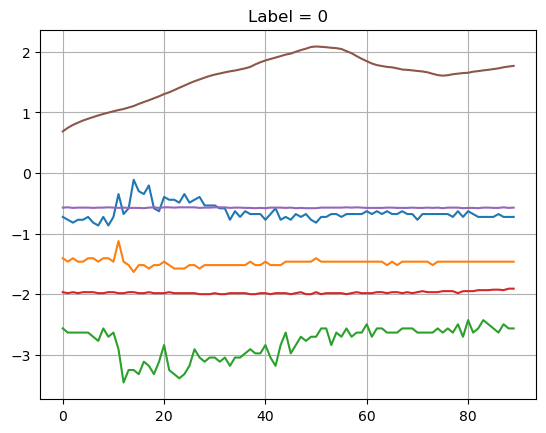

Resampled Train Class Balance: Counter({4: 885, 0: 885, 2: 885, 3: 885, 1: 885})


In [70]:
def load_and_preprocess(subject):
    path = f'/Users/veeralpatel/ECE284FinalProject/data/{subject}_PSG_df_updated.csv'
    df = pd.read_csv(path, usecols=channels + ['Sleep_Stage'])
    df = df.iloc[::100].reset_index(drop=True)  # Downsample from 100Hz → 1Hz
    df['Sleep_Stage'] = df['Sleep_Stage'].map(stage_map)
    df = df.dropna(subset=['Sleep_Stage'])
    df['Sleep_Stage'] = df['Sleep_Stage'].astype(int)
    for col in channels:
        df[col] = (df[col] - df[col].mean()) / df[col].std()
    return df

def extract_contextual_epochs(df, window=30):
    X_segments, y_segments = [], []
    for i in range(window, len(df) - 2*window, window):
        prev_chunk = df.iloc[i-window:i]
        curr_chunk = df.iloc[i:i+window]
        next_chunk = df.iloc[i+window:i+2*window]

        if curr_chunk["Sleep_Stage"].nunique() == 1:
            combined = pd.concat([prev_chunk, curr_chunk, next_chunk])
            X_segments.append(combined[channels].values)  
            y_segments.append(curr_chunk["Sleep_Stage"].iloc[0])
    
    return np.stack(X_segments), np.array(y_segments)


X_all, y_all = [], []
for subject in subjects:
    df = load_and_preprocess(subject)
    X_seg, y_seg = extract_contextual_epochs(df)

    X_all.append(X_seg)
    y_all.append(y_seg)

X = np.concatenate(X_all)
y = np.concatenate(y_all)
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42) #SPLITTING DSRET HERE

#over-sampling
X_flat = X_train.reshape(len(X_train), -1)
ros = RandomOverSampler(random_state=42)
X_resampled, y_train = ros.fit_resample(X_flat, y_train)
X_train = X_resampled.reshape(-1, WINDOW, len(channels))


class SleepDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]
train_loader = DataLoader(SleepDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(SleepDataset(X_val, y_val), batch_size=32)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

In [71]:
class SleepDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = SleepDataset(X, y)
train_len = int(0.8 * len(dataset))
train_set, val_set = random_split(dataset, [train_len, len(dataset) - train_len])
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)


class CNN_BiLSTM_Model(nn.Module):
    def __init__(self, input_channels=6, num_classes=5):
        super(CNN_BiLSTM_Model, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=5)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(128)

        self.norm = nn.LayerNorm(128)
        self.lstm = nn.LSTM(128, 128, batch_first=True, bidirectional=True, dropout=0.3)

        self.fc1 = nn.Linear(256, 64)
        self.dropout = nn.Dropout(0.6)  
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = F.relu(self.bn2(self.conv2(x)))
        x = x.permute(0, 2, 1)
        x = self.norm(x)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.dropout(F.relu(self.fc1(x)))
        return self.fc2(x)


In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F

model = CNN_BiLSTM_Model(input_channels=6, num_classes=5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

EPOCHS = 50
best_val_loss = float('inf')

for epoch in range(EPOCHS):
    model.train()
    train_loss, train_correct, total = 0, 0, 0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += (out.argmax(1) == yb).sum().item()
        total += yb.size(0)

    train_acc = train_correct / total

    # === Validate ===
    model.eval()
    val_loss, val_correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for xb, yb in val_loader:
            out = model(xb)
            loss = criterion(out, yb)
            preds = out.argmax(1)

            val_loss += loss.item()
            val_correct += (preds == yb).sum().item()
            total += yb.size(0)

            all_preds.extend(preds.tolist())
            all_labels.extend(yb.tolist())

    val_acc = val_correct / total
    avg_val_loss = val_loss / len(val_loader)
    scheduler.step(avg_val_loss)

    print(f"Epoch {epoch+1:02d} | Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f} | Val Loss: {avg_val_loss:.4f}")



/opt/homebrew/anaconda3/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 01 | Train Acc: 0.663 | Val Acc: 0.719 | Val Loss: 0.9543
✅ Saved best model
Epoch 02 | Train Acc: 0.743 | Val Acc: 0.765 | Val Loss: 0.8624
✅ Saved best model
Epoch 03 | Train Acc: 0.759 | Val Acc: 0.759 | Val Loss: 0.8664
Epoch 04 | Train Acc: 0.769 | Val Acc: 0.788 | Val Loss: 0.8109
✅ Saved best model
Epoch 05 | Train Acc: 0.779 | Val Acc: 0.774 | Val Loss: 0.8076
✅ Saved best model
Epoch 06 | Train Acc: 0.794 | Val Acc: 0.774 | Val Loss: 0.8085
Epoch 07 | Train Acc: 0.796 | Val Acc: 0.819 | Val Loss: 0.7692
✅ Saved best model
Epoch 08 | Train Acc: 0.798 | Val Acc: 0.828 | Val Loss: 0.7574
✅ Saved best model
Epoch 09 | Train Acc: 0.780 | Val Acc: 0.828 | Val Loss: 0.7530
✅ Saved best model
Epoch 10 | Train Acc: 0.811 | Val Acc: 0.811 | Val Loss: 0.7583
Epoch 11 | Train Acc: 0.830 | Val Acc: 0.828 | Val Loss: 0.7196
✅ Saved best model
Epoch 12 | Train Acc: 0.824 | Val Acc: 0.819 | Val Loss: 0.7137
✅ Saved best model
Epoch 13 | Train Acc: 0.821 | Val Acc: 0.828 | Val Loss: 0.72

🔁 Smoothed Prediction Classification Report:
              precision    recall  f1-score   support

           W       0.38      0.18      0.24        51
          N1       0.00      0.00      0.00         6
          N2       0.68      0.93      0.79       226
          N3       0.00      0.00      0.00        13
           R       0.53      0.15      0.24        53

    accuracy                           0.65       349
   macro avg       0.32      0.25      0.25       349
weighted avg       0.58      0.65      0.58       349

✅ Validation Accuracy: 0.8968
              precision    recall  f1-score   support

           W       0.95      0.80      0.87        51
          N1       0.50      0.17      0.25         6
          N2       0.92      0.96      0.94       226
          N3       0.69      0.69      0.69        13
           R       0.82      0.87      0.84        53

    accuracy                           0.90       349
   macro avg       0.78      0.70      0.72       349
we

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


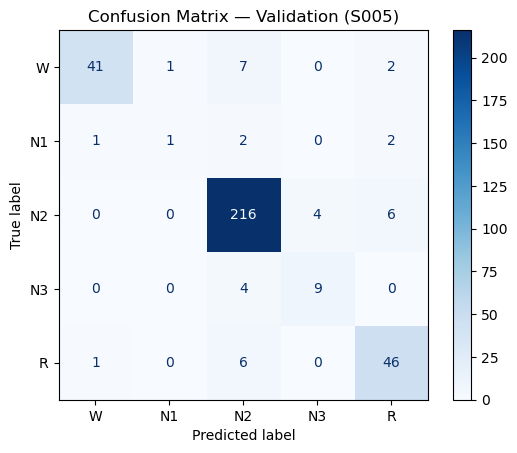

              precision    recall  f1-score   support

           0       0.95      0.80      0.87        51
           1       0.50      0.17      0.25         6
           2       0.92      0.96      0.94       226
           3       0.69      0.69      0.69        13
           4       0.82      0.87      0.84        53

    accuracy                           0.90       349
   macro avg       0.78      0.70      0.72       349
weighted avg       0.89      0.90      0.89       349



In [76]:
model.eval()
correct, total = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for xb, yb in val_loader:
        out = model(xb)
        preds = out.argmax(1)
        all_preds.extend(preds.tolist())
        all_labels.extend(yb.tolist())
        correct += (preds == yb).sum().item()
        total += yb.size(0)

# def smooth_predictions(preds, window=5):
#     return np.array([
#         stats.mode(preds[max(0, i - window//2): i + window//2 + 1], keepdims=True)[0][0]
#         for i in range(len(preds))
#     ])
# smoothed_preds = smooth_predictions(np.array(all_preds), window=5)

print("🔁 Smoothed Prediction Classification Report:")
print(classification_report(all_labels, smoothed_preds, target_names=["W", "N1", "N2", "N3", "R"]))

print(classification_report(all_labels, all_preds, target_names=["W", "N1", "N2", "N3", "R"], zero_division=0))
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["W", "N1", "N2", "N3", "R"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix — Validation (S005)")
plt.show()
print(classification_report(all_labels, all_preds, zero_division=0))
torch.save(model.state_dict(), "dreamt.pt")


✅ Classification Report on S005:
              precision    recall  f1-score   support

           W       0.90      0.71      0.79        92
          N1       0.40      0.05      0.09        39
          N2       0.88      0.98      0.93       478
          N3       0.00      0.00      0.00         5
           R       0.82      0.88      0.85       116

    accuracy                           0.87       730
   macro avg       0.60      0.52      0.53       730
weighted avg       0.84      0.87      0.85       730



/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


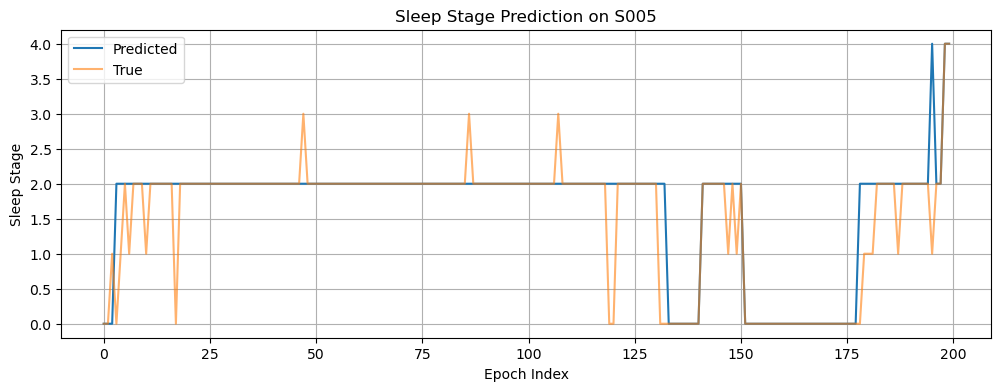

In [79]:

# df = pd.read_csv('/Users/veeralpatel/ECE284FinalProject/data/S005_PSG_df_updated.csv', usecols=[
#     'ACC_X', 'ACC_Y', 'ACC_Z', 'TEMP', 'EDA', 'HR', 'Sleep_Stage'
# ])

# stage_map = {"W": 0, "N1": 1, "N2": 2, "N3": 3, "R": 4}
# df['Sleep_Stage'] = df['Sleep_Stage'].map(stage_map)
# df = df.dropna(subset=['Sleep_Stage'])
# df['Sleep_Stage'] = df['Sleep_Stage'].astype(int)
# features = ["ACC_X", "ACC_Y", "ACC_Z", "TEMP", "EDA", "HR"]
# for col in features:
#     df[col] = (df[col] - df[col].mean()) / df[col].std()

# df = df.iloc[::100].reset_index(drop=True)  # from 100Hz → 1Hz
# WINDOW = 90  # 3-epoch context (30s * 3)

#
# X_segments, y_segments = [], []
# for i in range(30, len(df) - 60, 30):
#     prev = df.iloc[i - 30:i]
#     curr = df.iloc[i:i + 30]
#     next = df.iloc[i + 30:i + 60]

#     if curr["Sleep_Stage"].nunique() == 1:
#         combined = pd.concat([prev, curr, next])
#         X_segments.append(combined[features].values)  # (90, 6)
#         y_segments.append(curr["Sleep_Stage"].iloc[0])

# X = np.stack(X_segments)
# y = np.array(y_segments)

# X_tensor = torch.tensor(X, dtype=torch.float32)
# y_tensor = torch.tensor(y, dtype=torch.long)



with torch.no_grad():
    y_pred = model(X_tensor).argmax(dim=1)
print(classification_report(y_tensor, y_pred, target_names=["W", "N1", "N2", "N3", "R"]))



/var/folders/jd/lt8pv90x74741r8x6g2_d5lh0000gn/T/ipykernel_73376/1091388698.py:17: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/homebrew/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


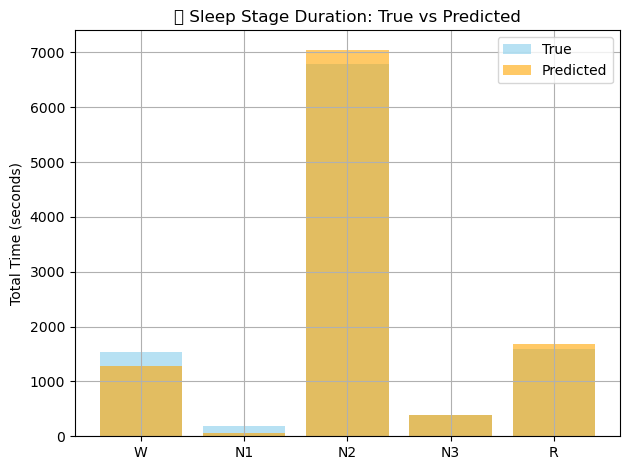

In [80]:
from collections import Counter
import matplotlib.pyplot as plt

true_counts = Counter(all_labels)
pred_counts = Counter(all_preds)

labels = ["W", "N1", "N2", "N3", "R"]
true_durations = [true_counts.get(i, 0) * 30 for i in range(5)]  # seconds
pred_durations = [pred_counts.get(i, 0) * 30 for i in range(5)]

plt.figure(figsize=(12, 4))
plt.plot(y_pred[:200], label="Predicted")
plt.plot(y_tensor[:200], label="True", alpha=0.6)
plt.title("Sleep Stage Prediction on S005")
plt.ylabel("Sleep Stage")
plt.xlabel("Epoch Index")
plt.legend()
plt.grid(True)
plt.show()

plt.bar(labels, true_durations, alpha=0.6, label="True", color='skyblue')
plt.bar(labels, pred_durations, alpha=0.6, label="Predicted", color='orange')
plt.ylabel("Total Time (seconds)")
plt.title("🔬 Sleep Stage Duration: True vs Predicted")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

labels = ["W", "N1", "N2", "N3", "R"]
true_counts = Counter(all_labels)
pred_counts = Counter(all_preds)

true_durations = [true_counts.get(i, 0) * 30 for i in range(5)]  # in seconds
pred_durations = [pred_counts.get(i, 0) * 30 for i in range(5)]

bar_width = 0.35
x = np.arange(len(labels))
plt.figure(figsize=(8, 4))
plt.bar(x - bar_width/2, true_durations, bar_width, label='True', color='skyblue')
plt.bar(x + bar_width/2, pred_durations, bar_width, label='Predicted', color='orange')
plt.xticks(x, labels)
plt.ylabel("Duration (seconds)")
plt.title("Sleep Stage Duration — True vs Predicted")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()



In [85]:
#torch.save(model.state_dict(), 'model_weights.pt')
model = torch.load('/Users/veeralpatel/ECE284FinalProject/MultiModal/model_weights.pt', map_location='cpu')
print(model)

OrderedDict({'conv1.weight': tensor([[[-0.0685, -0.2013,  0.0898, -0.0835, -0.1171],
         [-0.0651,  0.1800, -0.0489, -0.0743, -0.1745],
         [ 0.1195, -0.0429,  0.0241,  0.0004,  0.1269],
         [-0.0834, -0.1695, -0.1025,  0.0132,  0.1544],
         [ 0.1509, -0.1944,  0.0618, -0.1902, -0.0659],
         [ 0.0112,  0.0100,  0.0112, -0.0912,  0.1404]],

        [[-0.1659,  0.1453, -0.0074, -0.1175,  0.1729],
         [ 0.1143, -0.1340,  0.1705, -0.0414, -0.0667],
         [-0.1000,  0.0200, -0.0502,  0.0948, -0.1283],
         [-0.1688,  0.1016,  0.1348,  0.0265,  0.1958],
         [-0.2024,  0.1544,  0.0726, -0.1366,  0.1110],
         [ 0.0762, -0.0470, -0.2177, -0.2196, -0.1975]],

        [[ 0.1255, -0.0176,  0.1528, -0.0192, -0.2050],
         [ 0.0501,  0.0736, -0.0784, -0.0158,  0.1500],
         [-0.0138, -0.0692,  0.0652,  0.1885, -0.0024],
         [-0.0662, -0.0632, -0.0091, -0.0496,  0.1842],
         [-0.1895, -0.1178, -0.1709, -0.2353, -0.1835],
         [ 0.03

/var/folders/jd/lt8pv90x74741r8x6g2_d5lh0000gn/T/ipykernel_73376/1384092527.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/Users/veeralpatel/ECE284